<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/SatelliteSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

## Imports

In [ ]:
import os, datetime, math
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from seaborn import heatmap
from sklearn.utils import class_weight
from matplotlib import cm
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

from scipy.stats import randint

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 69.2MB 42kB/s 


In [ ]:
# only run on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline

## Global parameters

In [67]:
# paths
PATH = '/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/'

# use gpu if possible
TASK = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'

# set the pixel to extract
PIXEL_X = 16
PIXEL_Y = 16

# layers and step size
NUM_LAYERS = 1
STEP_SIZE = 1

# training iterations
ITERS = 1000

# random seed
SEED = 42

## Load data

In [ ]:
data = np.load(f'{PATH}train.npz')['bands']
labels = np.load(f'{PATH}train.npz')['lulc']

test = np.load(f'{PATH}hidden_test.npz')['bands']

classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

## Preprocessing

In [49]:
# Input: (n,12,33,33,6)
# Output: (n, 72*(1+max_padding))

def surrounding_pixel_means(data, num_layers, step_size):
  pixel_sets = []

  num_data_points = data.shape[0]

  # loop over 
  for i in range(1,num_layers+1, step_size):
    pixel_sets.append(data[:,:,PIXEL_X-i:PIXEL_X+i,PIXEL_Y-i:PIXEL_Y+i,:])

  # compute means for each of the sets per month and per channel:
  pixel_sets_mean = [np.mean(pixel_set, axis=(2,3)) for pixel_set in pixel_sets]

  # flatten month and channel data by reshaping:
  pixel_sets_mean_reshaped = [np.reshape(pixel_set,(num_data_points,12*6)) for pixel_set in pixel_sets_mean]

  # extract only center points:
  train_data_center_points = data[:,:,PIXEL_X,PIXEL_Y,:]
  train_data_center_points_reshaped = train_data_center_points.reshape(num_data_points,12*6)

  # combine sets:
  sets_combined = np.concatenate(pixel_sets_mean_reshaped, axis=1)

  # combine sets with central pixels:
  all_combined = np.concatenate((sets_combined, train_data_center_points_reshaped), axis=1)
  
  return all_combined

In [50]:
def preprocess(x, y, labels=None):
  x = x[y != 0, :, :, :, :] if labels == 'exclude_no_data' else x[y == 0, :, :, :, :] if labels == 'only_no_data' else x
  y = y[y != 0] if labels == 'exclude_no_data' else y[y == 0] if labels == 'only_no_data' else y

  x = surrounding_pixel_means(x, NUM_LAYERS, STEP_SIZE)

  x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify = y)

  return x_train, x_val, y_train, y_val

  # x[:, :, PIXEL_X, PIXEL_Y, :].reshape((x.shape[0], x.shape[1] * x.shape[-1]))

## Exploratory Data Analysis?

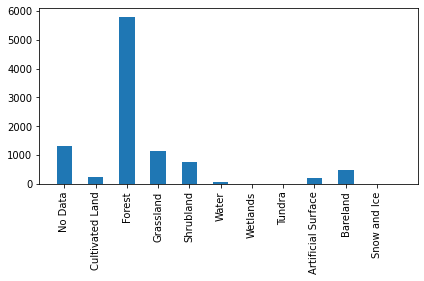

In [ ]:
plt.hist(labels, bins=list(range(len(classes) + 1)), width=0.5, align='mid')
plt.xticks(ticks=[i + 0.25 for i in range(len(classes))], labels=classes, rotation=90)
plt.tight_layout()
plt.show()

# Semi-Supervised Learning

## Training with only labelled data

In [51]:
# use only labelled data for training
x_train, x_val, y_train, y_val = preprocess(data, labels, 'exclude_no_data')
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

'train: (6953, 144) (6953,), validation: (1739, 144) (1739,)'

In [55]:
cbm = CatBoostClassifier(learning_rate=0.1, iterations=ITERS, random_seed=SEED, logging_level='Silent', task_type=TASK)
# fit on labelled data
cbm.fit(x_train, y_train)

In [56]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 77.82252265209262
F1-Score: [ 6.89655172 90.38637986 56.49595687 27.29468599  0.          6.66666667
 66.59898477]
              precision    recall  f1-score   support

           1       0.54      0.04      0.07       190
           2       0.86      0.96      0.90      4637
           3       0.55      0.58      0.56       900
           4       0.53      0.18      0.27       616
           5       0.00      0.00      0.00        46
           8       1.00      0.03      0.07       174
           9       0.55      0.84      0.67       390

    accuracy                           0.78      6953
   macro avg       0.58      0.38      0.36      6953
weighted avg       0.76      0.78      0.74      6953



Validation

Accuracy: 77.11328349626221
F1-Score: [ 0.         89.75609756 53.76344086 30.8411215   0.          8.88888889
 66.66666667]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        48
           2       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# fit the model on full labelled data, i. e. combine the splits
cbm.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))

## Predict labels for unlabelled data

In [57]:
# predict labels for unlabelled data
unlabelled_data = surrounding_pixel_means(data[labels == 0], NUM_LAYERS, STEP_SIZE)

predicted_labels = cbm.predict(unlabelled_data).reshape(-1)

In [59]:
# train the model on labelled training instances and add predicted labels
x_train = np.concatenate((x_train, unlabelled_data))
y_train = np.concatenate((y_train, predicted_labels))
cbm.fit(x_train, y_train)

In [60]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

Training

Accuracy: 80.14768187870717
F1-Score: [ 0.         91.42905491 61.38962181 28.13953488  0.          1.1299435
 68.85813149]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       190
           2       0.88      0.96      0.91      5650
           3       0.59      0.64      0.61      1093
           4       0.54      0.19      0.28       637
           5       0.00      0.00      0.00        46
           8       1.00      0.01      0.01       176
           9       0.58      0.85      0.69       469

    accuracy                           0.80      8261
   macro avg       0.51      0.38      0.36      8261
weighted avg       0.77      0.80      0.77      8261



Validation

Accuracy: 77.05577918343876
F1-Score: [ 0.         89.91049634 54.15778252 28.01932367  0.          0.
 65.56016598]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        48
           2       0.85      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Hyperparameter Tuning:

In [ ]:
# Get default params:
print(cbm.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'MultiClass', 'iterations': 1000, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'grow_policy': 'SymmetricTree', 'boosting_type': 'Plain', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'devices': '-1', 'pinned_memory_bytes': '104857600', 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss_normalization': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'meta_l2_frequency': 0, 'class_names': [1, 2, 3, 4, 5, 8, 9], 'random_seed': 42, 'depth': 6, 'border_count': 128, 'min_fold_size': 100, 'data_partition': 'DocParallel', 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'min_data_in_leaf': 1, 'add_ridge_penalty_to_loss_function': False, 'loss

In [ ]:
# Creating the hyperparameter grid
# Based on Docs: https://catboost.ai/docs/concepts/python-reference_catboost_randomized_search.html

param_dist = {"learning_rate": np.linspace(0,0.2,5),
              "depth": randint(3, 10),
              "l2_leaf_reg":[1, 3, 5, 7],}

In [ ]:
#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbm , param_dist, scoring='accuracy', cv=4, n_iter=ITERS, n_jobs=-1)

In [ ]:
#Fit the model
rscv.fit(x_train, y_train)

In [ ]:
# Best model:
best_model = rscv.best_estimator_

# Best accuracy:
best_accuracy = rscv.best_score_
print("\n The best accuracy score across ALL searched params:\n",rscv.best_score_)

# Best params:
best_params = rscv.best_params_
print("\n The best parameters across ALL searched params:\n",rscv.best_params_)

## Full fit with only labelled data

In [62]:
# final step: fit the model on all labelled data
labelled_data = surrounding_pixel_means(data[labels != 0], NUM_LAYERS, STEP_SIZE)

labelled_data_labels = labels[labels != 0]
cbm.fit(labelled_data, labelled_data_labels)

## Full prediction of labels

In [65]:
# predict labels for unlabelled data
predicted_labels = cbm.predict(unlabelled_data).reshape(-1)

# overwrite existing labels without label
new_labels = labels.copy()
new_labels[labels == 0] = predicted_labels

## Fit final model on full data

In [66]:
# fit model with full data
full_data = surrounding_pixel_means(data, NUM_LAYERS, STEP_SIZE)

cbm.fit(full_data, new_labels)

# Results

## Metrics

## Visualization

In [ ]:
test_transformed = []
for i in range(1500):
  for j in range(1500):
    pixel = test[:, i, j, :].reshape((72,))
    test_transformed.append(pixel)

test_transformed = np.array(test_transformed)

pred = cbm.predict(test_transformed).reshape((1500, 1500))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


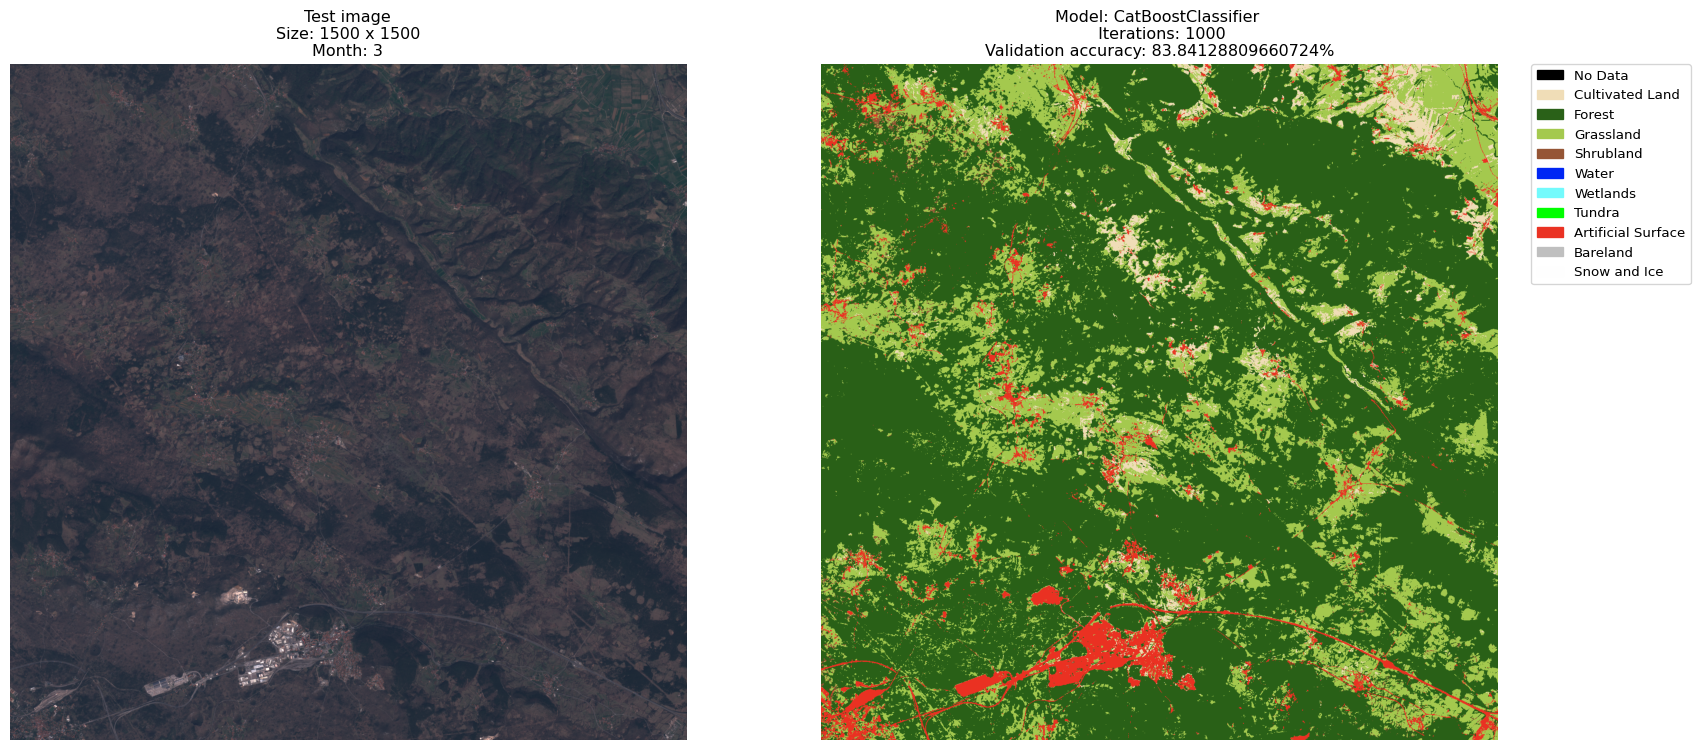

In [ ]:
plot_result(test, pred)

### Visualization Functions


In [ ]:
def plot_result(image, pred):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20), dpi=96)

  # Plot correct image:
  # Load September
  band_sep = image[3, :, :, :3]
  # Flip from BGR to RGB
  band_flip = np.flip(band_sep, -1)
  # bright
  band_flip = band_flip + 0.3

  # Change Contrast
  c_fact = 2.5
  band = 0.5 + c_fact * (band_flip - 0.5)

  ax1.axis('off')
  ax1.imshow(band, cmap='gray')
  ax1.set_title(f'Test image\nSize: 1500 x 1500\nMonth: {3}')

  # Plot prediction
  image = np.empty((pred.shape[0], pred.shape[1], 4))
  for i in range(0, pred.shape[0]):
      for j in range(0, pred.shape[1]):
          image[i, j] = class_to_color(pred[i, j].astype(int))
  ax2.axis('off')
  im_ax2 = ax2.imshow(image)

  # Generate legend for prediction
  label_colors = [classes_color[i]['color'] for i in range(len(classes_color))]
  label_title = [classes_color[i]['label'] for i in range(len(classes_color))]
  # create a patch (proxy artist) for every color
  patches = [mpatches.Patch(color=label_colors[i], label=label_title[i])
              for i in range(len(label_title))]
  # put those patched as legend-handles into the legend
  plt.legend(handles=patches, bbox_to_anchor=(
      1.05, 1), loc=2, borderaxespad=0.)
  ax2.set_title(f'Model: CatBoostClassifier \n Iterations: {ITERS}\nValidation accuracy: {accuracy_score(y_val, cbm_val)*100}%')

  return plt.show()

In [ ]:
def class_to_color(label):
    if (label < len(classes_color)):
        return classes_color[label]["color"]
    return [0, 0, 0]

In [ ]:
classes_color = [{  # Index 0
    "label": "No Data",
    "color": [0, 0, 0, 1]
}, {  # Index 1
    "label": "Cultivated Land",
    "color": [241/256, 222/256, 184/256, 1]
}, {  # Index 2
    "label": "Forest",
    "color": [42/256, 97/256, 24/256, 1]
}, {  # Index 3
    "label": "Grassland",
    "color": [165/256, 202/256, 79/256, 1]
}, {  # Index 4
    "label": "Shrubland",
    "color": [150/256, 85/256, 53/256, 1]
}, {  # Index 5
    "label": "Water",
    "color": [0, 38/256, 245/256, 1]
}, {  # Index 6
    "label": "Wetlands",
    "color": [115/256, 251/256, 253/256, 1]
}, {  # Index 7
    "label": "Tundra",
    "color": [0, 255/256, 0, 1]
}, {  # Index 8
    "label": "Artificial Surface",
    "color": [235/256, 50/256, 35/256, 1]
}, {  # Index 9
    "label": "Bareland",
    "color": [192/256, 192/256, 192/256, 1]
}, {  # Index 10
    "label": "Snow and Ice",
    "color": [255/256, 255/256, 255/256, 1]
}
]

## Sliding Window

### Sliding Window Functions

In [ ]:
def calc_mean_from_sorounding(padding, patch, center_X, center_Y):
  # Calculate the means for the given padding
  center_point_month_and_channel = current_patch[:, patch_padding, patch_padding, :]
  center_point = center_point_month_and_channel.reshape((1,6*12))
  new_patch = center_point
  for i in range(0, patch_padding, 1):
    patch_mean = np.mean(current_patch[:, patch_padding-i:patch_padding+i, patch_padding-i:patch_padding+i, :], axis=(1,2))
    patch_mean_reshaped = numpy.reshape(patch_mean,(1,12*6))
    new_patch = numpy.append(new_patch, patch_mean_reshaped, axis=1)


# Input: (n,12,33,33,6)
# Output: (n, 72*(1+max_padding))

In [ ]:
def generate_sliding_window_batches(model, test_data, patch_padding):
  """
  This function enables predicting datasets that are bigger than
  the training data.

  input shape from test_data: 12, 500, 500, 6
  Output shape: 250'000, 72 * (patch_padding + 1)
  """

  test_size = test_data.shape[1]
  patches = numpy.empty((test_size, test_size, 12 * 6 * (patch_padding+1)))

  # Augment Data with mirrored padding to keep structure for points on the edge
  padded_bands = []

  for month in range(12):
      padded_bands.append(numpy.pad(test_data[month], ((patch_padding,patch_padding), (patch_padding,patch_padding), (0,0)), "symmetric"))

  padded_bands = numpy.asarray(padded_bands)

  # Predict labels in batches 
  for h in range(test_size):
    patches_row = np.empty((test_size, 12 * 6 * (patch_padding+1)))

    # Collect all patches for one row
    for w in range(test_size):
      center_y = h + patch_padding
      center_x = w + patch_padding
      current_patch = padded_bands[:, center_y - patch_padding:center_y + patch_padding + 1, center_x - patch_padding:center_x + patch_padding + 1, :]

      # if CatBoost, reshape patch
      if(isinstance(model, CatBoostClassifier)):
        center_point_month_and_channel = current_patch[:, patch_padding, patch_padding, :]
        center_point = center_point_month_and_channel.reshape((1,6*12))
        new_patch = center_point

        # Calculate the means for the given padding
        for i in range(0, patch_padding, 1):
          patch_mean = numpy.mean(current_patch[:, patch_padding-i:patch_padding+i, patch_padding-i:patch_padding+i, :], axis=(1,2))
          patch_mean_reshaped = numpy.reshape(patch_mean,(1,12*6))
          new_patch = numpy.append(new_patch, patch_mean_reshaped, axis=1)
        current_patch = new_patch

      # Put together the patches from one row
      patches_row[w] = current_patch

    # Put together the rows
    patches[h] = patches_row

  return patches

In [ ]:
def predict(slided_batch, model, patch_padding):
  predictions = []
  test_size = slided_batch.shape[0]

  temp_preds = model.predict(slided_batch.reshape(test_size * test_size, 12 * 6 * (patch_padding+1)))

  return prediction.reshape((test_size,test_size))

## Export

In [ ]:
# save plot, model and predictions
f.savefig(f'{PATH}plot.png')
np.save(f'{PATH}predictions.npy', pred)
cbm.save_model(f'{PATH}model')